In [1]:
import numpy as np
import pandas as pd
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.classifier import StackingClassifier
from vecstack import stacking
from sklearn.calibration import CalibratedClassifierCV
pd.set_option('max_columns',30)

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from xgboost.sklearn import XGBClassifier

In [68]:
train=pd.read_csv('/Users/shashank/Downloads/cogni/train_DaEJRFg.csv')
test=pd.read_csv('/Users/shashank/Downloads/cogni/test_TQDFDgg.csv')
submissions=pd.read_csv('/Users/shashank/Downloads/cogni/sample_submission_n2Tyn0h.csv')

In [69]:
print train.shape,test.shape

(11777, 12) (5048, 11)


In [70]:
train.head()

,victim_id,incident_time,incident_date,incident_location,incident_tehsil,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,roadway_feature,road_type,surrounding_area,criticality
0,VIC20120001987267,22:23:19,07-11-2012,Subhash Nagar,Raipur,Multiple Vehicular Incident,13,12,CUR,HIW,FOR,0
1,VIC20110002147887,20:23:09,02-11-2011,Coro Nation,Raipur,2 Wheeler accidents,1,5,CUR,HIW,AGL,0
2,VIC20090001391483,20:37:15,25-07-2009,Kewal Vihar,Raipur,"Non motorised vehicle accidents(Bullock cart,B...",2,2,INT,LOC,HOSP,0
3,VIC20120000900722,15:20:22,19-05-2012,I S B T,Raipur,2 Wheeler accidents,8,4,CUR,HIW,HIL,0
4,VIC20100001241285,16:22:17,12-06-2010,Sahaspur Ambu,Sahaspur,2 Wheeler accidents,1,26,CUR,HIW,AGL,0


In [71]:
train.incident_time=train.incident_time.apply(lambda x: datetime.datetime.strptime(str(x),'%H:%M:%S'))
test.incident_time=test.incident_time.apply(lambda x: datetime.datetime.strptime(str(x),'%H:%M:%S'))

train['Hour']=train.incident_time.apply(lambda x: x.hour)
test['Hour']=test.incident_time.apply(lambda x: x.hour)

In [72]:
train.incident_date=train.incident_date.apply(lambda x: datetime.datetime.strptime(str(x),'%d-%m-%Y'))
test.incident_date=test.incident_date.apply(lambda x: datetime.datetime.strptime(str(x),'%d-%m-%Y'))

In [73]:
train['Year']=train.incident_date.apply(lambda x: x.year)
train['Month']=train.incident_date.apply(lambda x: x.month)
train['Day']=train.incident_date.apply(lambda x: x.day)
train['Weekday']=train.incident_date.apply(lambda x: x.weekday())
train['Ordinal']=train.incident_date.apply(lambda x: x.toordinal())


test['Year']=test.incident_date.apply(lambda x: x.year)
test['Month']=test.incident_date.apply(lambda x: x.month)
test['Day']=test.incident_date.apply(lambda x: x.day)
test['Weekday']=test.incident_date.apply(lambda x: x.weekday())
test['Ordinal']=test.incident_date.apply(lambda x: x.toordinal())

In [74]:
train.criticality.value_counts()

0    11255
1      522
Name: criticality, dtype: int64

In [75]:
train.shape

(11777, 18)

In [76]:
# train[predictors].head()

In [77]:
def encoder(train,col):
    le=LabelEncoder()
    le.fit(train[col])
    train[col]=le.transform(train[col])

In [78]:
encoder(train,'incident_tehsil')
encoder(train,'cause_of_emergency')
encoder(train,'road_type')
encoder(train,'surrounding_area')
encoder(train,'roadway_feature')


In [79]:
encoder(test,'incident_tehsil')
encoder(test,'cause_of_emergency')
encoder(test,'road_type')
encoder(test,'surrounding_area')
encoder(test,'roadway_feature')

In [80]:
## notes
## though lv is 0.802986718337 without incident_tehsil pub lb score is 0.8177130369
## though lv is 0.800149027487 without roadway feature pub lb score is 0.8183451938!

## best lv is with onehotted cause 0.805702910463
## also consider calibrated model with label encoding 0.803

In [115]:
n=['victim_id','incident_time','incident_date','criticality','KNN','RF','ET','XGB','incident_location',
  'incident_tehsil','roadway_feature','road_type','surrounding_area']
predictors=[x for x in train.columns if x not in n ]
target='criticality'

In [116]:
train[predictors].head()

,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,Hour,Year,Month,Day,Weekday,Ordinal
0,9,13,12,22,2012,11,7,2,734814
1,0,1,5,20,2011,11,2,2,734443
2,10,2,2,20,2009,7,25,5,733613
3,0,8,4,15,2012,5,19,5,734642
4,0,1,26,16,2010,6,12,5,733935


In [99]:
xg=XGBClassifier(learning_rate=0.1,n_estimators=100)
score=cross_val_score(estimator=xg,cv=10,scoring='roc_auc',X=train[predictors],y=train[target])
print score.mean()

0.802053338572


In [192]:
xg=XGBClassifier(learning_rate=0.1,)
score=cross_val_score(estimator=xg,cv=10,scoring='roc_auc',X=train[predictors],y=train[target])
print score.mean()

0.80126864532


In [180]:
xg

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [260]:
cal=CalibratedClassifierCV(base_estimator=XGBClassifier(learning_rate=0.1),method='sigmoid',cv=10)
score=cross_val_score(estimator=cal,cv=10,scoring='roc_auc',X=train[predictors],y=train[target])
print score.mean()

0.805125438171


,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,Hour,Year,Month,Day,Weekday
0,9,13,12,22,2012,11,7,2
1,0,1,5,20,2011,11,2,2
2,10,2,2,20,2009,7,25,5
3,0,8,4,15,2012,5,19,5
4,0,1,26,16,2010,6,12,5


In [18]:
# q1=train.scene_to_hospital_distance.quantile(0.25)
# q3=train.scene_to_hospital_distance.quantile(0.75)
# iqr=q3-q1
# Q1=q1-1.5*iqr
# Q3=q3+1.5*iqr
#train=train[train.scene_to_hospital_distance<Q3]

In [253]:
test[predictors].head()

,base_to_scene_distance,scene_to_hospital_distance,2 Wheeler accidents,Auto (3 Wheeler accidents),Extrication>20mts,MCI,MVC - Pedestrian (Run Over/Hit & Run),MVC-Fixed object (Divider),MVC-MV,MVC-Non traffic inside a parked vehicle/Skidding,...,Multiple Vehicular Incident,"Non motorised vehicle accidents(Bullock cart,Bicycle,Rickshaw,Push cart)",Railroad Train/Other Object,Vehicle -Fall From Height etc.,Vehicle role over/Skid,Hour,Year,Month,Day,Weekday
0,23,27,0,0,0,0,1,0,0,0,...,0,0,0,0,0,15,2010,5,19,2
1,5,21,0,0,0,0,0,0,0,0,...,1,0,0,0,0,16,2012,3,18,6
2,3,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,18,2013,1,4,4
3,18,14,0,0,0,0,0,0,0,0,...,1,0,0,0,0,16,2014,5,31,5
4,6,10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,15,2009,12,8,1


In [23]:
# ones=train[train.criticality==1]
# zeros=train[train.criticality==0]
# zeros=zeros.sample(10000,random_state=42)
#train=(pd.concat([zeros,ones],ignore_index=True))

11255

In [38]:
X_train,X_test,y_train,y_test=train_test_split(train[predictors],train[target],test_size=0.3)

In [39]:
def run(X,y,test,params):
    dtrain=xgb.DMatrix(X,label=y)
    dtest=xgb.DMatrix(test)
    bst=xgb.train(params,dtrain,89)
    preds=bst.predict(dtest)
    return bst,preds

params={
    'objective':'binary:logistic',
    'eta':0.1
}

In [40]:
bst,probs=run(X_train,y_train,X_test,params)
print roc_auc_score(y_test,probs)
preds=(probs>=0.5).astype('int')
print accuracy_score(y_test,preds)
print confusion_matrix(y_test,preds)

0.775172807657
0.94646816598
[[2979    8]
 [ 161    9]]


In [41]:
bst,probs=run(X_train,y_train,X_test,params)
print roc_auc_score(y_test,probs)
preds=(probs>=0.5).astype('int')
print accuracy_score(y_test,preds)
print confusion_matrix(y_test,preds)

0.775172807657
0.94646816598
[[2979    8]
 [ 161    9]]


In [462]:
# xg=XGBClassifier(learning_rate=0.1,)
# score=cross_val_score(estimator=xg,cv=10,scoring='roc_auc',X=train[predictors],y=train[target])
# print score.mean()

0.77581215519


In [128]:
# bst,probs=run(train[predictors].values,train[target].values,test[predictors].values,params)

In [117]:
xg=XGBClassifier(learning_rate=0.1,n_estimators=100)
xg.fit(train[predictors],train[target])
probs=xg.predict_proba(test[predictors])
probs=probs[:,1]

In [101]:
# cal=CalibratedClassifierCV(base_estimator=XGBClassifier(learning_rate=0.1),method='sigmoid',cv=10)
# cal.fit(train[predictors],train[target])
# probs=cal.predict_proba(test[predictors])
# probs=probs[:,1]

In [102]:
probs

array([ 0.07348813,  0.09322818,  0.03110322, ...,  0.05223532,
        0.31350681,  0.04106973], dtype=float32)

In [103]:
probs

array([ 0.07348813,  0.09322818,  0.03110322, ...,  0.05223532,
        0.31350681,  0.04106973], dtype=float32)

In [121]:
submissions['criticality']=f

In [122]:
submissions.to_csv('/Users/shashank/Downloads/cogni/%i.csv'%i,index=False)
i=i+1

In [48]:
# i=20

In [120]:
sub1=pd.read_csv('/Users/shashank/Downloads/cogni/39.csv')[target]
sub2=pd.read_csv('/Users/shashank/Downloads/cogni/38.csv')[target]
f=0.5*sub1+0.5*sub2

In [125]:
# models = [
#     ExtraTreeClassifier(),
        
#     KNeighborsClassifier(n_neighbors=4),
    
#     RandomForestClassifier(),
        
#     XGBClassifier(learning_rate=0.1)]
    
# # Compute stacking features
# S_train, S_test = stacking(models, train[predictors].values, train[target].values, test[predictors].values, 
#     regression = False, metric = accuracy_score, n_folds = 10, 
#     stratified = True, shuffle = True, random_state = 0, verbose = 2)

In [146]:
train=pd.concat([train,pd.DataFrame(S_train,columns=['ET','KNN','RF','XGB'])],axis=1)
test=pd.concat([test,pd.DataFrame(S_test,columns=['ET','KNN','RF','XGB'])],axis=1)

In [114]:
train[predictors].head()

,incident_tehsil,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,Hour,Year,Month,Day,Weekday
0,4,9,13,12,22,2012,11,7,2
1,4,0,1,5,20,2011,11,2,2
2,4,10,2,2,20,2009,7,25,5
3,4,0,8,4,15,2012,5,19,5
4,5,0,1,26,16,2010,6,12,5


In [302]:
test[predictors].head()

,incident_tehsil,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,roadway_feature,road_type,surrounding_area,Hour,Year,Month,Day,Weekday,ET,RF,XGB
0,5,4,23,27,1,1,5,15,2010,5,19,2,0.0,0.0,0.0
1,2,9,5,21,0,0,0,16,2012,3,18,6,0.0,0.0,0.0
2,4,9,3,1,0,0,0,18,2013,1,4,4,0.0,0.0,0.0
3,5,9,18,14,4,1,0,16,2014,5,31,5,0.0,0.0,0.0
4,6,0,6,10,1,1,5,15,2009,12,8,1,0.0,0.0,0.0


In [148]:
len(train[train.KNN==1])

21

In [149]:
len(train[train.RF==1])

37

In [329]:
len(probs[probs>0.5])

267

In [160]:
np.exp(probs)

array([ 1.08839643,  1.099666  ,  1.0344975 , ...,  1.05296052,
        1.26491749,  1.04043543], dtype=float32)

In [161]:
probs

array([ 0.08470544,  0.09500655,  0.0339158 , ...,  0.05160568,
        0.23500693,  0.03963929], dtype=float32)

In [427]:
df=pd.concat([train,test])

In [428]:
train[predictors].tail()

,cause_of_emergency,base_to_scene_distance,scene_to_hospital_distance,Hour,Year,Month,Day,Weekday
11772,9,4,3,23,2012,6,13,2
11773,0,1,2,0,2011,3,3,3
11774,0,25,22,20,2009,7,18,5
11775,9,8,8,6,2014,6,23,0
11776,13,8,3,16,2010,5,9,6


In [429]:
df.cause_of_emergency.nunique()

14

In [430]:
d=pd.concat([df,pd.get_dummies(df.cause_of_emergency)],axis=1)

In [431]:
d.drop(['cause_of_emergency'],axis=1,inplace=True)

In [432]:
d.reset_index(drop=True,inplace=True)

In [433]:
test=d.iloc[11777:,:]
train=d.iloc[:11777,:]

In [434]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [435]:
# m1=train.base_to_scene_distance.mean()
# s1=train.base_to_scene_distance.std()

# m2=train.scene_to_hospital_distance.mean()
# s2=train.scene_to_hospital_distance.std()

# train.base_to_scene_distance=(train.base_to_scene_distance-m1)/s1
# test.base_to_scene_distance=(test.base_to_scene_distance-m1)/s1

# train.scene_to_hospital_distance=(train.scene_to_hospital_distance-m2)/s2
# test.scene_to_hospital_distance=(test.scene_to_hospital_distance-m2)/s2

In [438]:
train[predictors].head()

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,scene_to_hospital_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,7,22,11,2,2012,13,12,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,20,11,2,2011,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,20,7,5,2009,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,19,15,5,5,2012,8,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,16,6,5,2010,1,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [439]:
test[predictors].head()

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,scene_to_hospital_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,19,15,5,2,2010,23,27,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,18,16,3,6,2012,5,21,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4,18,1,4,2013,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,31,16,5,5,2014,18,14,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,8,15,12,1,2009,6,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [402]:
train[predictors].head()

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,scene_to_hospital_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,7,22,11,2,2012,1.043899,0.486067,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,20,11,2,2011,-0.982974,-0.292280,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,20,7,5,2009,-0.814068,-0.625857,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,19,15,5,5,2012,0.199369,-0.403473,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,16,6,5,2010,-0.982974,2.042761,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [410]:
test[predictors].head()

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,scene_to_hospital_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,19,15,5,2,2010,2.732960,2.153953,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,18,16,3,6,2012,-0.307350,1.486799,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4,18,1,4,2013,-0.645162,-0.737050,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,31,16,5,5,2014,1.888430,0.708452,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,8,15,12,1,2009,-0.138444,0.263682,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [443]:
train.groupby(['criticality']).median()

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,incident_tehsil,road_type,roadway_feature,scene_to_hospital_distance,surrounding_area,0,1,2,3,4,5,6,7,8,9,10,11,12,13
criticality,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,16,16,6,3,2012,5,4,0,1,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1.0,16,16,7,3,2011,6,4,0,1,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


{'boxes': [<matplotlib.lines.Line2D at 0x116c31190>],
 'caps': [<matplotlib.lines.Line2D at 0x116c31990>,
 'fliers': [<matplotlib.lines.Line2D at 0x116c45510>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x116c45150>],
 'whiskers': [<matplotlib.lines.Line2D at 0x116fcd290>,
  <matplotlib.lines.Line2D at 0x116c31590>]}

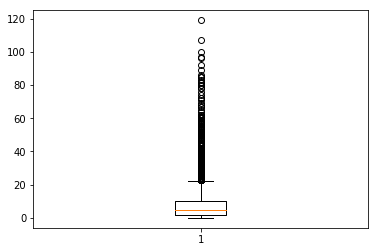

In [448]:
plt.boxplot(train.scene_to_hospital_distance)

In [450]:
train.scene_to_hospital_distance.median()

5.0

In [455]:
train.scene_to_hospital_distance.max()

119

In [458]:
train[train.scene_to_hospital_distance>50]

,Day,Hour,Month,Weekday,Year,base_to_scene_distance,criticality,incident_date,incident_location,incident_tehsil,incident_time,road_type,roadway_feature,scene_to_hospital_distance,surrounding_area,victim_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13
48,26,16,3,2,2014,50,0.0,2014-03-26,Kuwanu,0,1900-01-01 16:44:30,1,4,55,0,VIC20140000313297,0,0,0,0,0,0,0,0,1,0,0,0,0,0
112,5,12,5,1,2009,8,1.0,2009-05-05,.Chakrata M. H Hospital,0,1900-01-01 12:49:32,0,3,92,2,VIC20090000780286,1,0,0,0,0,0,0,0,0,0,0,0,0,0
182,12,11,10,5,2013,31,1.0,2013-10-12,Chakrata Ambu,0,1900-01-01 11:22:31,1,1,83,1,VIC20130001266655,0,0,0,0,0,0,0,0,0,1,0,0,0,0
358,15,9,7,3,2010,1,1.0,2010-07-15,"Govt ,Hos Chakrata",0,1900-01-01 09:47:04,0,1,57,5,VIC20100001512916,0,0,0,0,0,0,0,0,1,0,0,0,0,0
401,27,19,1,4,2012,49,0.0,2012-01-27,Maletha,0,1900-01-01 19:17:51,0,0,78,0,VIC20120000139722,0,0,0,0,0,0,0,0,0,0,0,0,1,0
632,3,21,10,4,2014,1,0.0,2014-10-03,Tyuni Ambu,0,1900-01-01 21:38:40,1,4,100,3,VIC20140001240014,0,0,0,0,0,0,0,0,0,0,0,0,0,1
684,5,20,11,4,2010,1,0.0,2010-11-05,Phc Tyuni,0,1900-01-01 20:17:03,1,1,62,5,VIC20100002239629,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1040,19,14,4,3,2012,26,1.0,2012-04-19,NaN,0,1900-01-01 14:11:19,0,0,54,3,VIC20120000677444,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1099,7,14,9,6,2014,1,0.0,2014-09-07,Ift From Phc Tyun,0,1900-01-01 14:34:00,1,4,51,0,VIC20140001125819,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1293,12,11,10,5,2013,1,0.0,2013-10-12,Phc Tyuni,0,1900-01-01 11:15:00,1,1,52,1,VIC20130001266610,0,0,0,1,0,0,0,0,0,0,0,0,0,0
